In [9]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier  # Faster SVM alternative
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split

In [2]:
# Load the saved TF-IDF vectorizer
vectorizer = joblib.load("tfidf_vectorizer.pkl")

# Load the preprocessed dataset
df = pd.read_csv("Processed_SentimentData.csv")

In [3]:
# Transform text data using the saved vectorizer
X = vectorizer.transform(df['cleaned_statement'])
y = df['encoded_status']

In [11]:
# Use a **smaller subset** for training (reduces training time)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.2, random_state=42)

# Use **SGDClassifier** as a faster alternative to SVM
svm_model = SGDClassifier(loss="hinge", max_iter=500, tol=1e-3, random_state=42)
svm_model.fit(X_train, y_train)

# Save the trained model
joblib.dump(svm_model, "svm_model.pkl")
print("✅ Optimized SVM Model saved successfully!")

✅ Optimized SVM Model saved successfully!


In [15]:
# Load the saved model
svm_model = joblib.load("svm_model.pkl")
print("SVM Model loaded successfully!")

# Predictions
y_pred = svm_model.predict(X_test)

SVM Model loaded successfully!


In [17]:
# Function to predict sentiment of a given text
def predict_sentiment(text):
    text_tfidf = vectorizer.transform([text])  # Convert input text to TF-IDF
    prediction = svm_model.predict(text_tfidf)[0]  # Get predicted class
    return prediction

# Example Predictions
sample_texts = [
    "I feel so lost and hopeless.",
    "I'm extremely happy with my progress!",
    "Things are getting worse every day...",
    "Feeling okay, but still uncertain about the future."
]

for text in sample_texts:
    predicted_class = predict_sentiment(text)
    print(f"Text: {text}\nPredicted Sentiment: {predicted_class}\n")


Text: I feel so lost and hopeless.
Predicted Sentiment: 2

Text: I'm extremely happy with my progress!
Predicted Sentiment: 3

Text: Things are getting worse every day...
Predicted Sentiment: 3

Text: Feeling okay, but still uncertain about the future.
Predicted Sentiment: 3



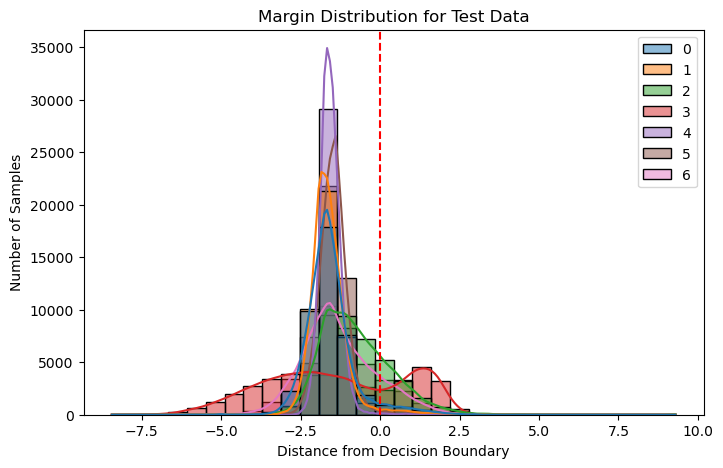

In [19]:
# Compute margin distances
decision_function = svm_model.decision_function(X_test)

plt.figure(figsize=(8,5))
sns.histplot(decision_function, bins=30, kde=True, color="blue")
plt.axvline(x=0, color='red', linestyle='--')  # Decision boundary (hyperplane)
plt.title("Margin Distribution for Test Data")
plt.xlabel("Distance from Decision Boundary")
plt.ylabel("Number of Samples")
plt.show()

In [21]:
# Count support vectors per class
support_vectors_count = svm_model.n_iter_  # How many times the model iterated?

print(f"Number of Iterations Before Convergence: {support_vectors_count}")

Number of Iterations Before Convergence: 20


In [23]:
# Get indices of hardest samples (closest to decision boundary)
hard_samples_indices = np.argsort(np.abs(decision_function))[:5]

print("\nHardest Text Samples to Classify:")
for index in hard_samples_indices:
    print(f"Text: {df.iloc[index]['cleaned_statement']}")
    print(f"Actual Label: {df.iloc[index]['encoded_status']}, Predicted: {svm_model.predict(X_test[index])[0]}\n")


Hardest Text Samples to Classify:
Text: 2    all wrong back off dear forward doubt stay in ...
5    every break you must be nervous like something...
6    i feel scared anxious what can i do and may my...
4    i m restless and restless it s been a month no...
1    trouble sleeping confused mind restless heart ...
3    i ve shifted my focus to something else but i ...
0                                           oh my gosh
Name: cleaned_statement, dtype: object
Actual Label: 2    0
5    0
6    0
4    0
1    0
3    0
0    0
Name: encoded_status, dtype: int64, Predicted: 3

Text: 2    all wrong back off dear forward doubt stay in ...
6    i feel scared anxious what can i do and may my...
0                                           oh my gosh
4    i m restless and restless it s been a month no...
1    trouble sleeping confused mind restless heart ...
5    every break you must be nervous like something...
3    i ve shifted my focus to something else but i ...
Name: cleaned_statement, dtype:

C:\Users\abcd\AppData\Local\Temp\ipykernel_8004\2473591491.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[feature_names[i] for i in top_indices], y=coefficients[top_indices], palette="coolwarm")


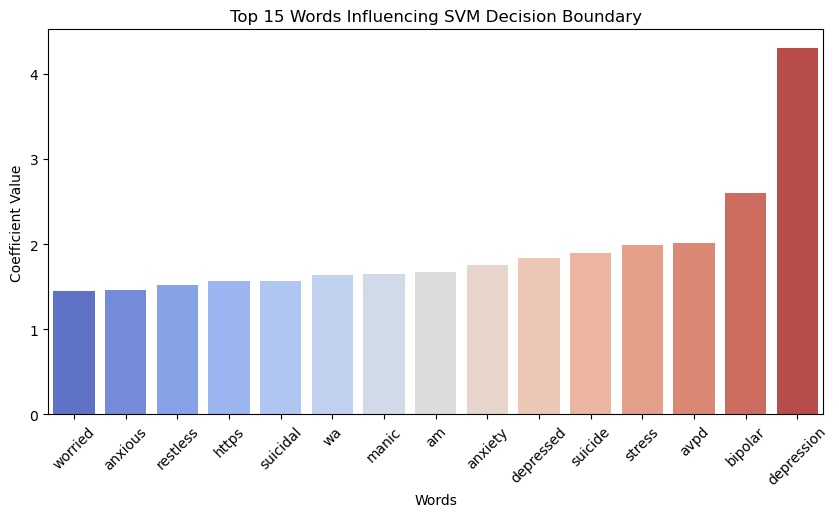

In [25]:
# Extract important features (weights)
feature_names = vectorizer.get_feature_names_out()
coefficients = np.abs(svm_model.coef_).mean(axis=0)  # Mean importance across classes
top_n = 15  # Select top 15 words
top_indices = np.argsort(coefficients)[-top_n:]

# Plot the most important words in the decision boundary
plt.figure(figsize=(10,5))
sns.barplot(x=[feature_names[i] for i in top_indices], y=coefficients[top_indices], palette="coolwarm")
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Coefficient Value")
plt.title("Top 15 Words Influencing SVM Decision Boundary")
plt.show()

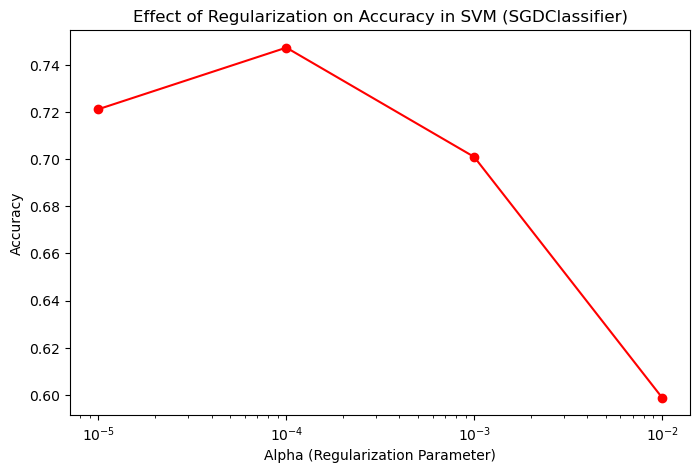

In [27]:
alpha_values = [0.01, 0.001, 0.0001, 0.00001]  # Equivalent to C-values in SVM
accuracies = []

for alpha in alpha_values:
    svm = SGDClassifier(loss="hinge", alpha=alpha, max_iter=500, tol=1e-3, random_state=42)
    svm.fit(X_train, y_train)
    acc = accuracy_score(y_test, svm.predict(X_test))
    accuracies.append(acc)

plt.figure(figsize=(8,5))
plt.plot(alpha_values, accuracies, marker="o", linestyle="-", color="red")
plt.xlabel("Alpha (Regularization Parameter)")
plt.ylabel("Accuracy")
plt.xscale("log")  # Log scale for better visualization
plt.title("Effect of Regularization on Accuracy in SVM (SGDClassifier)")
plt.show()